In [2]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from scipy.interpolate import interp1d

from deephyper.analysis._matplotlib import figure_size, update_matplotlib_rc

update_matplotlib_rc()
figsize = figure_size(252 * 1.8, 1.0)

In [3]:
class Experiment:
    task = "navalpropulsion"
    problem = "dhexp.benchmark.hpobench_tabular"
    search = "RANDOM"
    stopper = None
    stopper_args = None
    max_evals = 200
    random_state = None

    def __init__(self, stopper, stopper_args, random_state) -> None:
        self.stopper = stopper
        self.stopper_args = stopper_args
        self.random_state = random_state

    @property
    def log_dir(self):
        return f"{self.task}/output/{self.problem}-{self.search}-{self.stopper}-{self.stopper_args}-{self.max_evals}-{self.random_state}"

    @property
    def path_results(self):
        return os.path.join(self.log_dir, "results.csv")

    def load_results(self):
        return pd.read_csv(self.path_results, index_col=None)

In [28]:
import itertools

random_states = "1608637542 3421126067 4083286876  787846414 3143890026 3348747335 2571218620 2563451924  670094950 1914837113".split()

map_stopper_to_args = {
    "deephyper.stopper.ConstantStopper": "1 5 10 25 50 75 100".split(),
    "deephyper.stopper.SuccessiveHalvingStopper": "1.25 1.5 2 3 9".split(),
    "deephyper.stopper.LCModelStopper": "0.5 0.7 0.8 0.9 0.95".split(),
}

map_stopper_to_topk = {
    "deephyper.stopper.ConstantStopper": 3,
    "deephyper.stopper.SuccessiveHalvingStopper": 3,
    "deephyper.stopper.LCModelStopper": 3,
}

map_stopper_to_linestyle = {
    "deephyper.stopper.ConstantStopper": "-",
    "deephyper.stopper.SuccessiveHalvingStopper": "--",
    "deephyper.stopper.LCModelStopper": ":",
}

map_stopper_to_label = {
    "deephyper.stopper.ConstantStopper": "CST",
    "deephyper.stopper.SuccessiveHalvingStopper": "SHA",
    "deephyper.stopper.LCModelStopper": "LCE",
}

data = {
    "deephyper.stopper.ConstantStopper": {},
    "deephyper.stopper.SuccessiveHalvingStopper": {},
    "deephyper.stopper.LCModelStopper": {},
}

data_y_final = {
    "deephyper.stopper.ConstantStopper": [],
    "deephyper.stopper.SuccessiveHalvingStopper": [],
    "deephyper.stopper.LCModelStopper": [],
}


for stopper, stopper_items in data.items():
    for stopper_args, random_state in itertools.product(
        map_stopper_to_args[stopper], random_states
    ):
        exp = Experiment(stopper, stopper_args, random_state)
        df = exp.load_results()
        dfs = stopper_items.get(stopper_args, [])
        dfs.append(df)
        stopper_items[stopper_args] = dfs

In [29]:
from collections import deque

def process(df, mode="max", topk_tournament=None, filter_duplicates=False, max_budget=100):
    assert mode in ["min", "max"]
    
    if df.objective.dtype != np.float64:
        m = df.objective.str.startswith("F")
        df.loc[m,"objective"] = df.loc[m,"objective"].replace("F", "-1000000")
        df = df.astype({"objective": float})
        
    if mode == "min":
        df["objective"] = np.negative(df["objective"])
        if "m:objective_val" in df.columns:
            df["m:objective_val"] = np.negative(df["m:objective_val"])
        df["m:objective_test"] = np.negative(df["m:objective_test"])

    if topk_tournament:
        k = topk_tournament
        max_idx = []
        df["m:budget_cumsum"] = df["m:budget"].cumsum()
        for i in range(len(df)):
            fdf = df[:i+1]
            
            if filter_duplicates:
                fdf = fdf.drop_duplicates([pname for pname in df.columns if "p:" in pname], keep="last")
                
            if mode == "max":
                topk = fdf[:i+1].nlargest(n=k, columns="objective")
                if k == 1:
                    winner = topk
                else:
                    winner = topk.nlargest(n=1, columns="m:objective_val")
            else:
                topk = fdf[:i+1].nsmallest(n=k, columns="objective")
                if k == 1:
                    winner = topk
                else:
                    winner = topk.nsmallest(n=1, columns="m:objective_val")
                
            # consider that checkpointed "weights" can be reloaded
            # df.loc[i,"m:budget_cumsum"] = df.loc[i,"m:budget_cumsum"] + len(topk) * 100 - topk["m:budget"].sum()
            
            # consider that selected models are retrained from scratch
            df.loc[i,"m:budget_cumsum"] = df.loc[i,"m:budget_cumsum"] + len(topk) * max_budget
            
            winner_idx = winner.index.tolist()[0]
            max_idx.append(winner_idx)
        
        df["max_idx"] = max_idx
        
    else:
        if mode == "max":
            df["objective_cummax"] = df["objective"].cummax()
        else:
            df["objective_cummax"] = df["objective"].cummin()
            
        df["m:budget_cumsum"] = df["m:budget"].cumsum()
        df["idx"] = df.index
        df = df.merge(df.groupby("objective_cummax")[["idx"]].first().reset_index(), on="objective_cummax")
        df.rename(columns={"idx_y": "max_idx"}, inplace=True)
        df.index  = df.idx_x.values
        del df["idx_x"]
        
        for idx in df["max_idx"]:
            if df.loc[idx, "m:budget"] < max_budget:
                df.loc[idx, "m:budget_cumsum"] = df.loc[idx, "m:budget_cumsum"] + max_budget
                
    return df

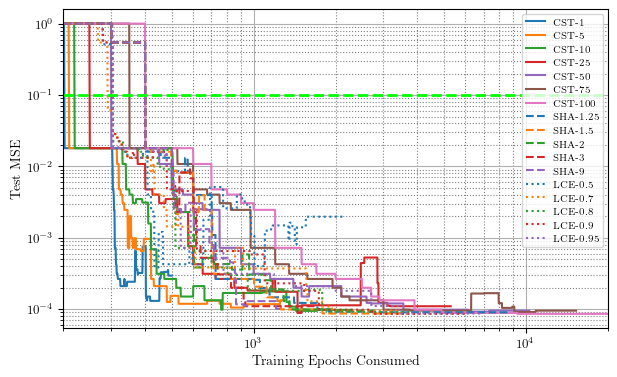

In [44]:
# https://matplotlib.org/stable/tutorials/colors/colormaps.html#lightness-of-matplotlib-colormaps
cmap = mpl.colormaps["tab10"]

plt.figure()

pf_x = []
pf_y = []

max_buget = 100
for i, (stopper, stopper_items) in enumerate(data.items()):
    for j, (stopper_args, dfs) in enumerate(stopper_items.items()):
        color = cmap(j)
        x_space = np.arange(1, 200 * max_buget + 1)
        dfs_processed = map(lambda x: process(x, mode="max", topk_tournament=map_stopper_to_topk[stopper]), dfs)
        x_max_j = 0
        y_list = []
        for j, df in enumerate(dfs_processed):
            x = df["m:budget_cumsum"].to_numpy()
            x_max_j = max(x[-1], x_max_j)

            y = df.loc[df["max_idx"]]["m:objective_test"].values
            f = interp1d(x, y, kind="previous", fill_value="extrapolate")
            y = -f(x_space)

            y_list.append(y)

        x = x_space[:x_max_j]
        y_list = np.asarray(y_list)
        y_list = y_list[:, :x_max_j]
        # y_mean = y_list.mean(axis=0)
        y_mean = np.median(y_list, axis=0)
        # y_stde = y_list.std(axis=0) / np.sqrt(len(y_list))
        y_min = np.quantile(y_list, q=0.25, axis=0)
        y_max = np.quantile(y_list, q=0.75, axis=0)

        data_y_final[stopper].append([x[-1], y_mean[-1]])

        plt.plot(
            x,
            y_mean,
            linestyle=map_stopper_to_linestyle[stopper],
            color=color,
            label=f"{map_stopper_to_label[stopper]}-{stopper_args}",
        )
        # plt.fill_between(x, y_min, y_max, alpha=0.2, color=color)

plt.axhline(0.1, linestyle="--", color="lime", linewidth=2)

plt.xlabel("Training Epochs Consumed")
plt.ylabel("Test MSE")
# plt.ylabel("Objective")
plt.xscale("log")
# plt.xlim(100, 200 + 3*100)
plt.xlim(200, max_buget * 200)
plt.yscale("log")
plt.grid()
plt.grid(visible=True, which="minor", color="gray", linestyle=":")
plt.legend()
plt.savefig(os.path.join(exp.task, "curves.jpg"), dpi=300, bbox_inches="tight")
plt.show()

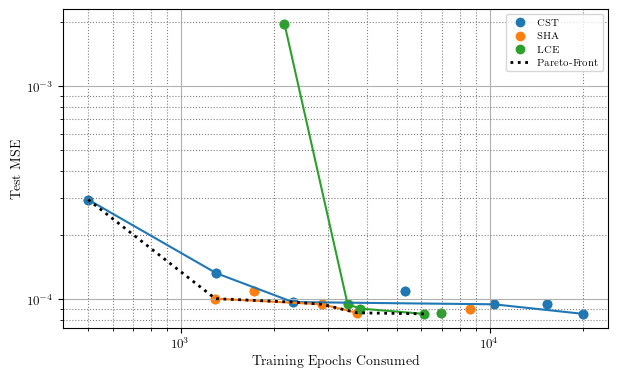

In [45]:
from deephyper.skopt.moo import non_dominated_set, pareto_front

# y = np.array([[y0,y1] for y0, y1 in zip(pf_x, pf_y)])
# mask = non_dominated_set(y)

y_all = []

plt.figure(figsize=figsize)

for i, (stopper, y) in enumerate(data_y_final.items()):
    y_all.extend(y)
    y = np.array(y)
    pf = pareto_front(y, sort=True)
    plt.scatter(y[:,0], y[:,1], color=f"C{i}", label=map_stopper_to_label[stopper])
    plt.plot(pf[:,0], pf[:,1])

y_all = np.array(y_all)
pf = pareto_front(y_all, sort=True)
plt.plot(pf[:,0], pf[:,1], color="black", linewidth=2, linestyle=":", label="Pareto-Front")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training Epochs Consumed")
plt.ylabel("Test MSE")
plt.legend()
plt.grid()
plt.grid(visible=True, which="minor", color="gray", linestyle=":")
plt.savefig(os.path.join(exp.task, "pf.jpg"), dpi=300, bbox_inches="tight")
plt.show()